In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
from scipy.integrate import trapz,simps
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from colossus.cosmology import cosmology

In [3]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [4]:
cosmo.Om0, cosmo.Omde, cosmo.ns, cosmo.H0, cosmo.relspecies = 0.29, 0.71, 0.97, 70, False
#cosmo.OmbO = 0.02247
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "planck15" 
    flat = True, Om0 = 0.2900, Ode0 = 0.7100, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9700
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


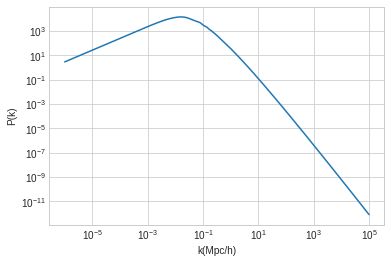

In [6]:
k = 10 ** np.linspace(-6, 5, 100000)
Pk = cosmo.matterPowerSpectrum(k, 0.57)

plt. figure()
plt.loglog()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-')
plt.show()

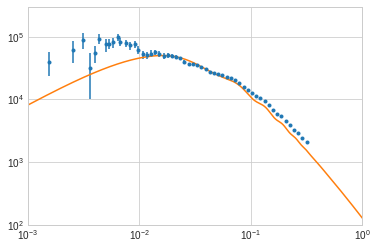

In [7]:
#Data and related paper here: http://www.sdss3.org/science/boss_publications.php

pk_cmasdr12 = np.loadtxt("/home/mimimustaine/Downloads/GilMarin_etal_2016ab_DR12CMASSLOWZ_powspec/GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt").T
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.')
plt.plot(k, 1.85 ** 2 * Pk, '-')
plt.xlim(1e-3, 1)
plt.ylim(100, 3e5)
plt.show()

In [9]:
from scipy.optimize import minimize

In [36]:
def Pk_Om(k, Om_, b, beta, z = 0.57):
    cosmo.Om0 = Om_
    return b ** 2 * (1 + beta) * cosmo.matterPowerSpectrum(k, z)

def likelihood(parametro, v):
    x, y, yerr = v[0], v[1], v[2]
    model = Pk_Om(x, parametro[0], parametro[1], parametro[2])
    chisq = (y - model) ** 2 / yerr ** 2
    return - 0.5 * chisq.sum()

def prior(parametro):
    if 0.001 < parametro[0] < 1.0 and 0.001 < parametro[1] < 5.0 and 0.001 < parametro[2] < 5.0:
        return 0.0
    return - np.inf

def ejecucion(parametro, v):
    prior_ = prior(parametro)
    if not np.isfinite(prior_):
        return - np.inf
    return likelihood(parametro, [pk_cmasdr12[0], pk_cmasdr12[1], pk_cmasdr12[2]]) + prior_

Maximum likelihood estimates:
m = 0.350
b = 2.005
f = 0.114


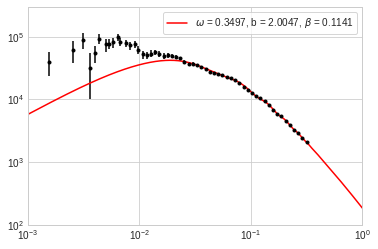

In [37]:
np.random.seed(42)
nll = lambda *args: - likelihood(*args)
#"Valores reales"
om_true, b_true, beta_true = 0.3, 2.0301228, 0.05332122
initial = np.array([om_true, b_true, beta_true]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=pk_cmasdr12)
om_ml, b_ml, beta_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(om_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(beta_ml))

plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt=".k", capsize=0)
plt.plot(k, Pk_Om(k, om_ml, b_ml, beta_ml), color = 'red', label = '$\\omega$ = {0}, b = {1}, $\\beta$ = {2}'.format(np.round(om_ml, 4), np.round(b_ml, 4), np.round(beta_ml, 4)))
plt.legend(frameon = True)
plt.xlim(1e-3, 1)
plt.ylim(100, 3e5)
plt.show()

In [25]:
def likelihood(parametro, x, y, yerr):
    model = Pk_Om(x, parametro[0], parametro[1], parametro[2])
    chisq = (y - model) ** 2 / yerr ** 2
    return - 0.5 * chisq.sum()

In [28]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood, args = pk_cmasdr12)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████| 2000/2000 [25:09<00:00,  1.33it/s] 


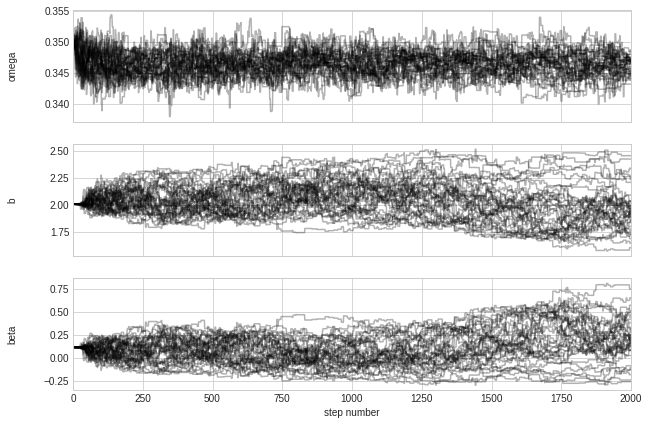

In [30]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["omega", "b", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(4032, 3)


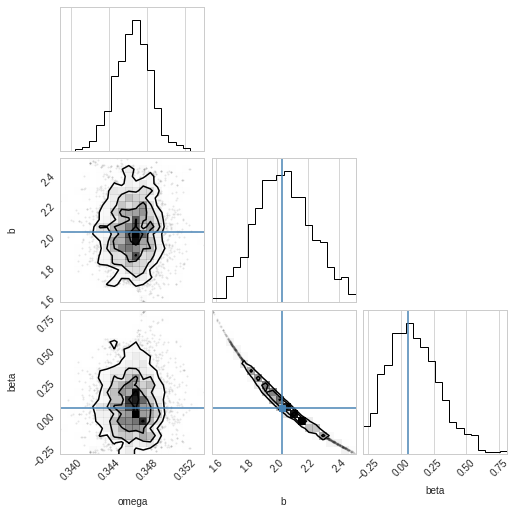

In [33]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[om_true, b_true, beta_true]
);

In [34]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

SyntaxError: invalid syntax (<ipython-input-34-d838a5321b4f>, line 4)